# Import Dependensi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.formula.api import ols

# Import Data

In [2]:
df_gravimetri = pd.read_csv('hasil/ET Aktual Gravimetri.csv')
df_bc = pd.read_csv('hasil/Estimasi ET Blaney-Criddle.csv')
df_hs = pd.read_csv('hasil/Estimasi ET Hargreaves-Samani.csv')
df_pm = pd.read_csv('hasil/Estimasi ET Penman-Monteith.csv')

# Plot Hasil Evapotranspirasi

## Plot Gravimetri

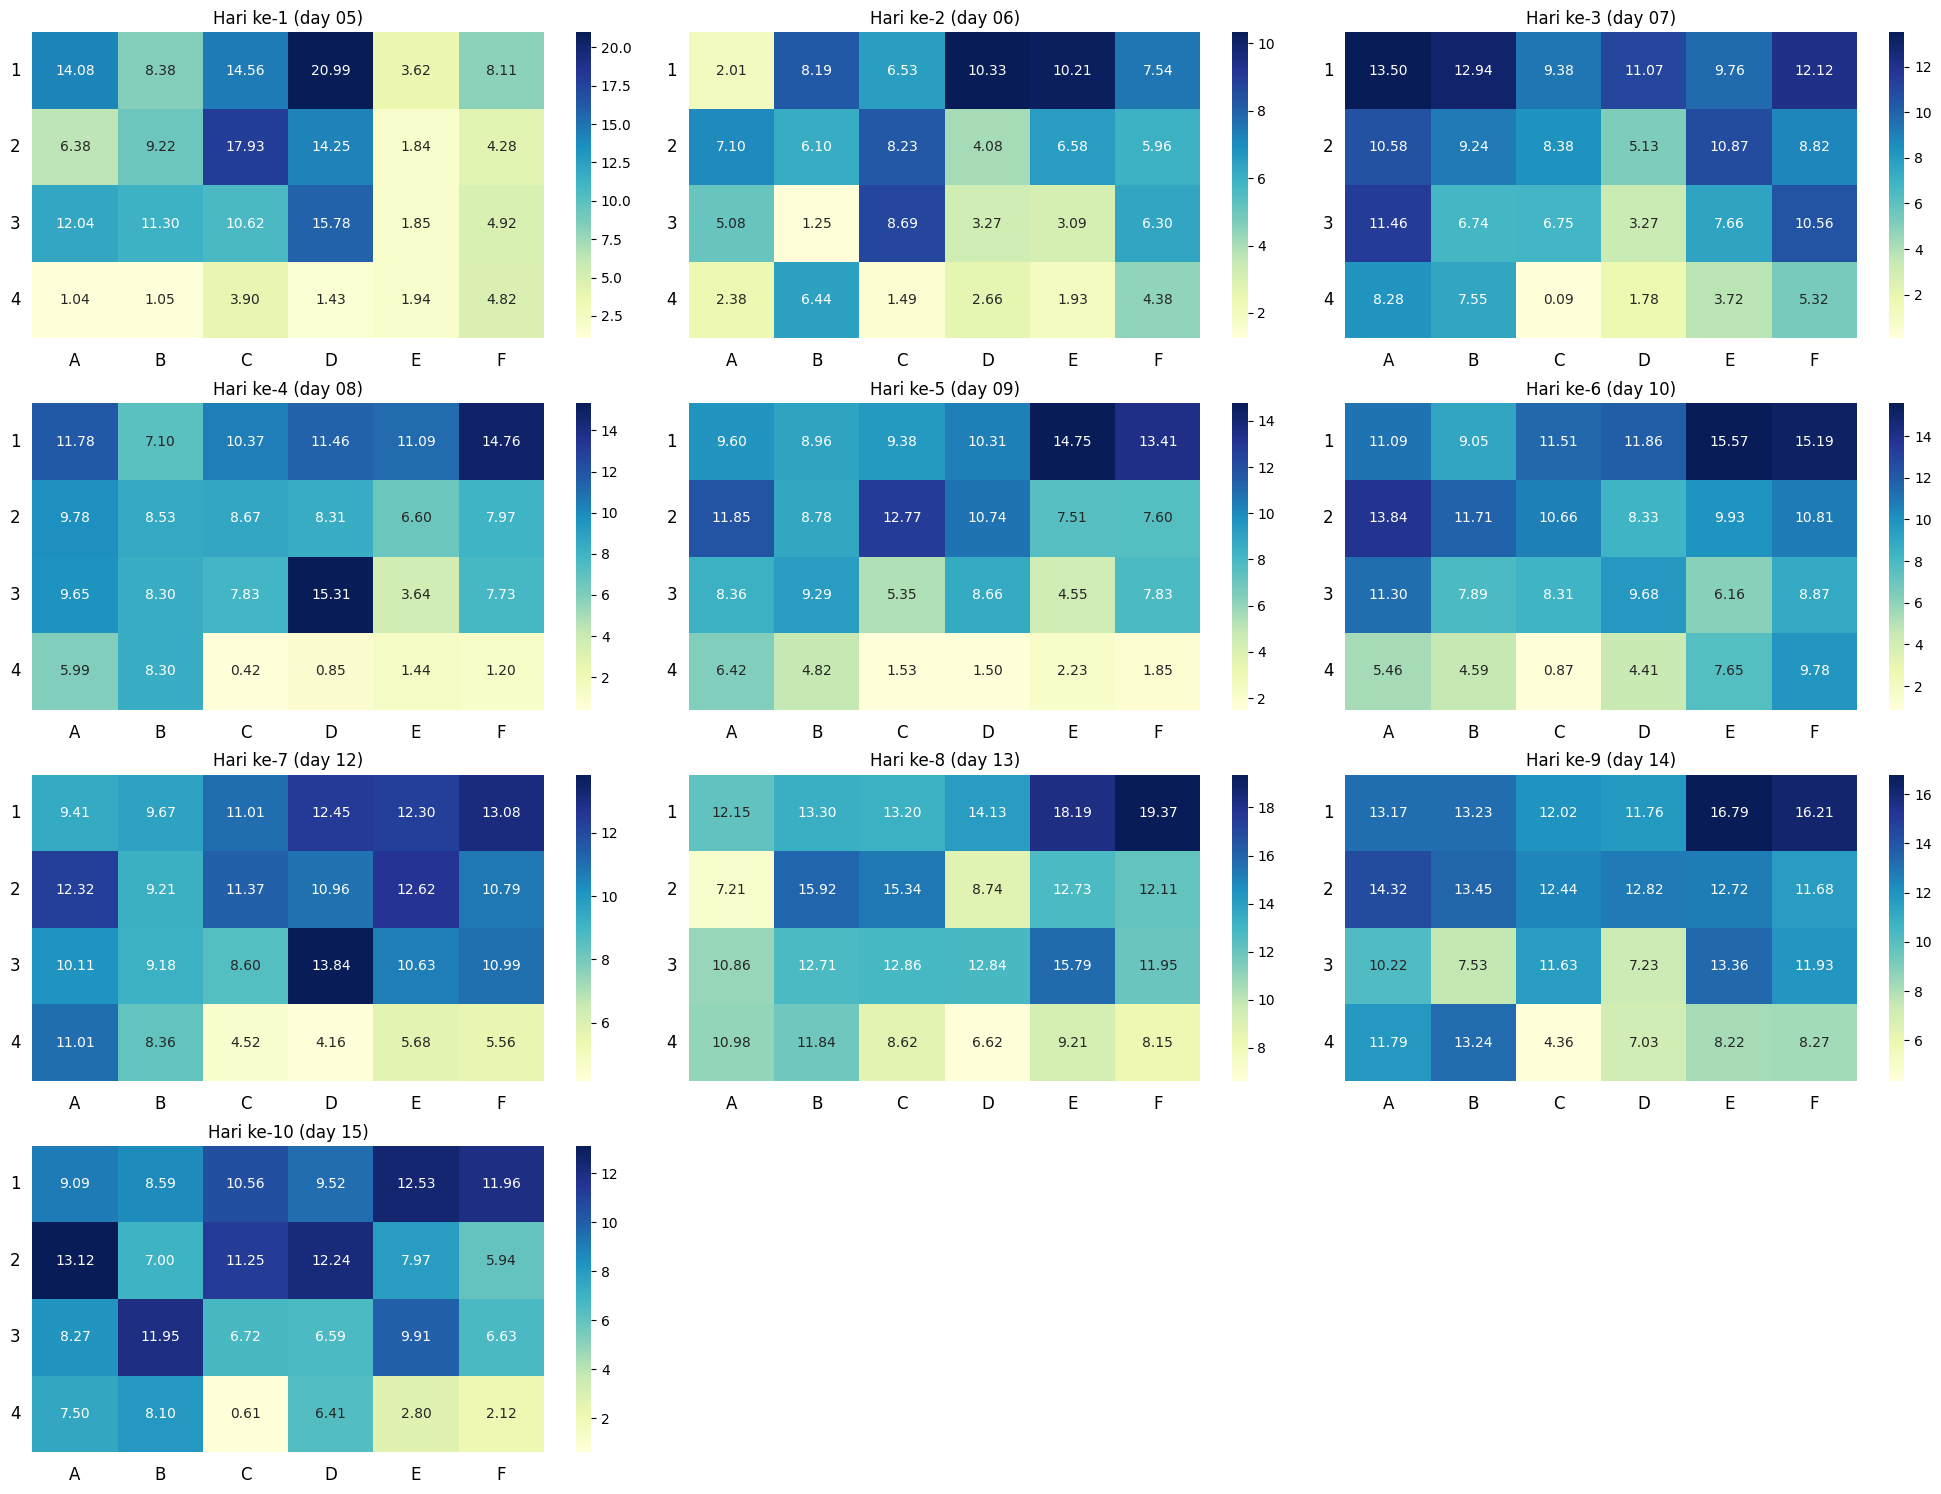

In [3]:
df_gravimetri.set_index('Num Day', inplace=True)

# Plot heatmaps
fig, axes = plt.subplots(4, 3, figsize=(20, 15))  # 4x3 grid
axes = axes.flatten()

for i, (day, data) in enumerate(df_gravimetri.iterrows()):
    # Reshape data untuk heatmap
    day_data = data.values.reshape(4, 6)  # Reshape ke (4x6)
    
    # Plot heatmap
    sns.heatmap(
        day_data, annot=True, fmt=".2f", cmap="YlGnBu",
        xticklabels=[], yticklabels=[], ax=axes[i]
    )
    axes[i].set_title(f"Hari ke-{i+1} ({day})")

    # Tambahkan label X (A-F) dan Y (1-4)
    for col in range(6):
        axes[i].text(col + 0.5, 4.3, f"{chr(65 + col)}", ha="center", va="center", fontsize=12)
    for row in range(4):
        axes[i].text(-0.2, row + 0.5, f"{row + 1}", ha="center", va="center", fontsize=12)

# Hilangkan subplot kosong jika jumlah hari kurang dari 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Plot Metode Estimasi

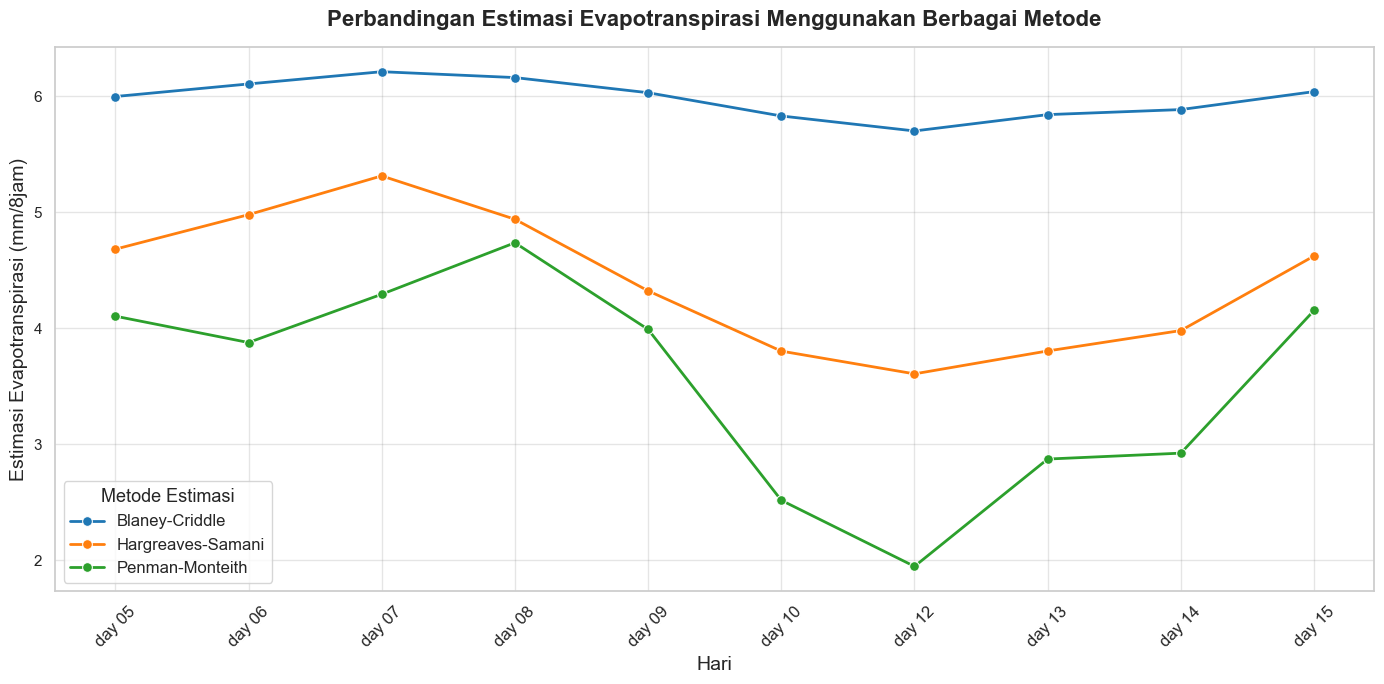

In [4]:
sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(14, 7))

# Plot data Blaney-Criddle
sns.lineplot(
  x=df_bc['Num Day'], y=df_bc['ET Total'], marker='o', label='Blaney-Criddle', color='#1f77b4', markersize=7, linewidth=2)

# Plot data Hargreaves-Samani
sns.lineplot(x=df_hs['Num Day'], y=df_hs['ET Total'], marker='o', label='Hargreaves-Samani', color='#ff7f0e', markersize=7, linewidth=2)

# Plot data Penman-Monteith dengan
sns.lineplot(x=df_pm['Num Day'], y=df_pm['ET Total'], marker='o', label='Penman-Monteith', color='#2ca02c', markersize=7, linewidth=2)

plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=16, weight='bold', pad=15)
plt.xlabel('Hari', fontsize=14)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(
  title='Metode Estimasi', 
  fontsize=12, 
  title_fontsize='13', 
  frameon=True
)

plt.tight_layout()
plt.show()

# RM 1 - Analisis Parameter

In [5]:
# Pastikan kolom aktual adalah numerik
aktual = df_gravimetri.apply(pd.to_numeric, errors='coerce')

# Pastikan estimasi juga numerik
estimasi_bc = np.array(df_bc['ET Total'], dtype=float)
estimasi_hs = np.array(df_hs['ET Total'], dtype=float)
estimasi_pm = np.array(df_pm['ET Total'], dtype=float)

## Akurasi

In [6]:
# Fungsi menghitung akurasi
def akurasi(aktual, estimasi):
  error = np.abs(np.mean(estimasi) - np.mean(aktual)) / np.mean(aktual)
  akurasi = (1 - error) * 100
  return akurasi


In [7]:
akurasi_bc = {}
akurasi_hs = {}
akurasi_pm = {}

for col in aktual.columns:
    akurasi_bc[col] = akurasi(aktual[col], estimasi_bc)
    akurasi_hs[col] = akurasi(aktual[col], estimasi_hs)
    akurasi_pm[col] = akurasi(aktual[col], estimasi_pm)
    

df_akurasi = pd.DataFrame({
    'Blanet-Criddle': akurasi_bc,
    'Hargreaves-Samani': akurasi_hs,
    'Penman-Monteith': akurasi_pm
}).T

df_akurasi.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Blanet-Criddle,56.489839,60.162644,55.123770,48.282022,47.927645,45.401308,56.168959,60.316337,51.104102,62.575716,...,68.466105,62.015242,78.039234,68.193024,84.419330,80.513664,-26.464110,37.709733,66.534941,83.730463
Hargreaves-Samani,41.606559,44.311697,40.600407,35.561242,35.300232,33.439504,41.370221,44.424897,37.639793,46.089001,...,50.427459,45.676194,57.478373,50.226327,62.177516,59.300869,33.201995,80.468067,98.301252,85.636205
Penman-Monteith,33.443235,35.617617,32.634492,28.584026,28.374227,26.878579,33.253267,35.708607,30.254759,37.046209,...,40.533449,36.714396,46.200954,40.371780,49.978112,47.665872,65.928234,96.079430,79.014269,68.834140


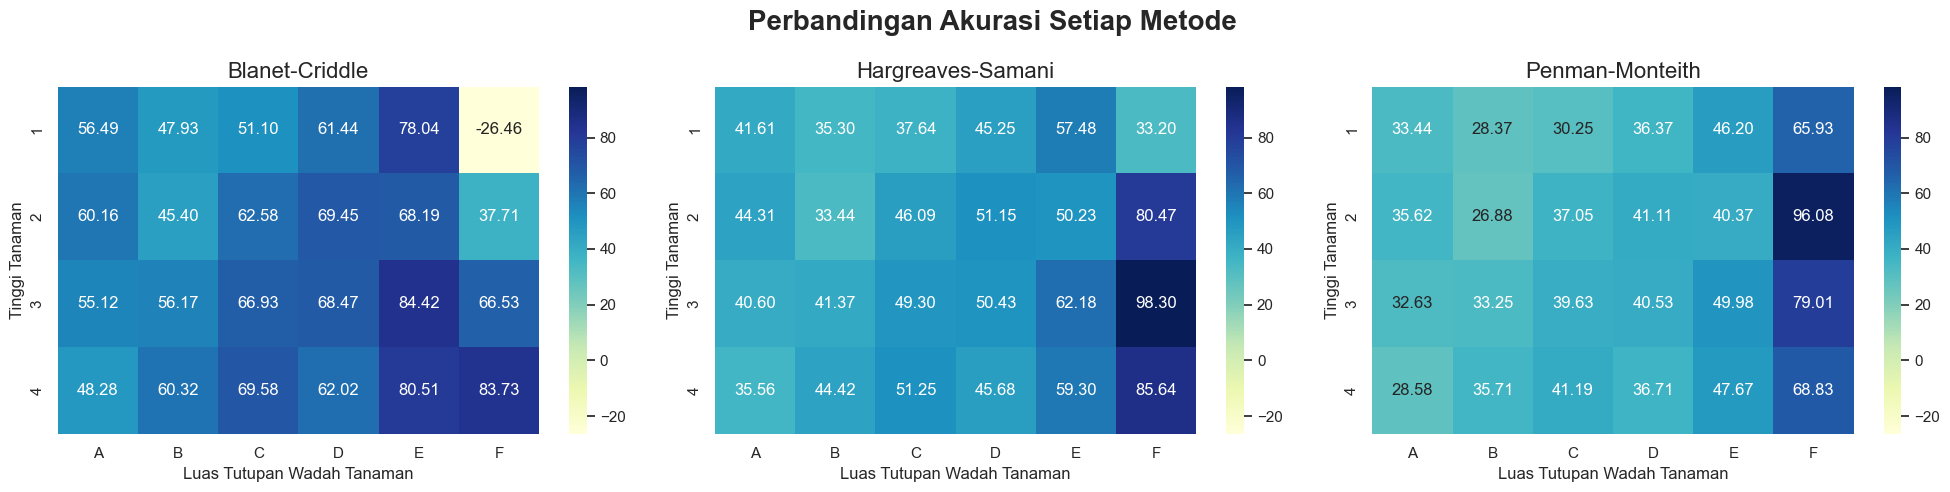

In [23]:
# Pastikan kolom dataframe dalam format string
df_akurasi.columns = df_akurasi.columns.astype(str)

# Ekstraksi kategori (A-F) dan nomor (1-4) dari kolom
df_akurasi.columns = [col[0] + col[1] for col in df_akurasi.columns.str.extract(r'([A-F])([1-4])').values]
df_akurasi.index.name = "Metode"

# Reshape data
df_akurasi_long = df_akurasi.reset_index().melt(id_vars="Metode", var_name="CategoryNumber", value_name="Akurasi")
df_akurasi_long[['Category', 'Number']] = df_akurasi_long['CategoryNumber'].str.extract(r'([A-F])([1-4])')
df_akurasi_long.drop(columns=['CategoryNumber'], inplace=True)

# Menentukan rentang warna (vmin, vmax) berdasarkan data keseluruhan
vmin = df_akurasi_long['Akurasi'].min()
vmax = df_akurasi_long['Akurasi'].max()

# Generate heatmaps untuk setiap metode
methods = df_akurasi.index
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, method in enumerate(methods):
    # Filter data untuk metode tertentu
    heatmap_data = df_akurasi_long[df_akurasi_long['Metode'] == method].pivot(index="Number", columns="Category", values="Akurasi")
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax, ax=axes[i])
    axes[i].set_title(method, fontsize=16)
    axes[i].set_xlabel("Luas Tutupan Wadah Tanaman")
    axes[i].set_ylabel("Tinggi Tanaman")

fig.suptitle("Perbandingan Akurasi Setiap Metode", fontsize=20, weight='bold')
plt.tight_layout()
plt.show()

## Mean Absolute Error (MAE)

In [9]:
mae_bc = {}
mae_hs = {}
mae_pm = {}

# Menghitung MSE untuk setiap kolom
for col in aktual.columns:
    mae_bc[col] = mean_absolute_error(aktual[col], estimasi_bc)
    mae_hs[col] = mean_absolute_error(aktual[col], estimasi_bc)
    mae_pm[col] = mean_absolute_error(aktual[col], estimasi_bc)

df_mae = pd.DataFrame({
    'Blanet-Criddle': mae_bc,
    'Hargreaves-Samani': mae_hs,
    'Penman-Monteith': mae_pm
}).T

df_mae.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Blanet-Criddle,5.425614,3.96063,4.86943,6.40703,6.973928,7.193074,4.667519,3.937347,5.722916,4.200053,...,2.891924,4.820293,3.91705,3.005903,2.950365,2.927905,3.895264,2.753476,3.003887,2.566687
Hargreaves-Samani,5.425614,3.96063,4.86943,6.40703,6.973928,7.193074,4.667519,3.937347,5.722916,4.200053,...,2.891924,4.820293,3.91705,3.005903,2.950365,2.927905,3.895264,2.753476,3.003887,2.566687
Penman-Monteith,5.425614,3.96063,4.86943,6.40703,6.973928,7.193074,4.667519,3.937347,5.722916,4.200053,...,2.891924,4.820293,3.91705,3.005903,2.950365,2.927905,3.895264,2.753476,3.003887,2.566687


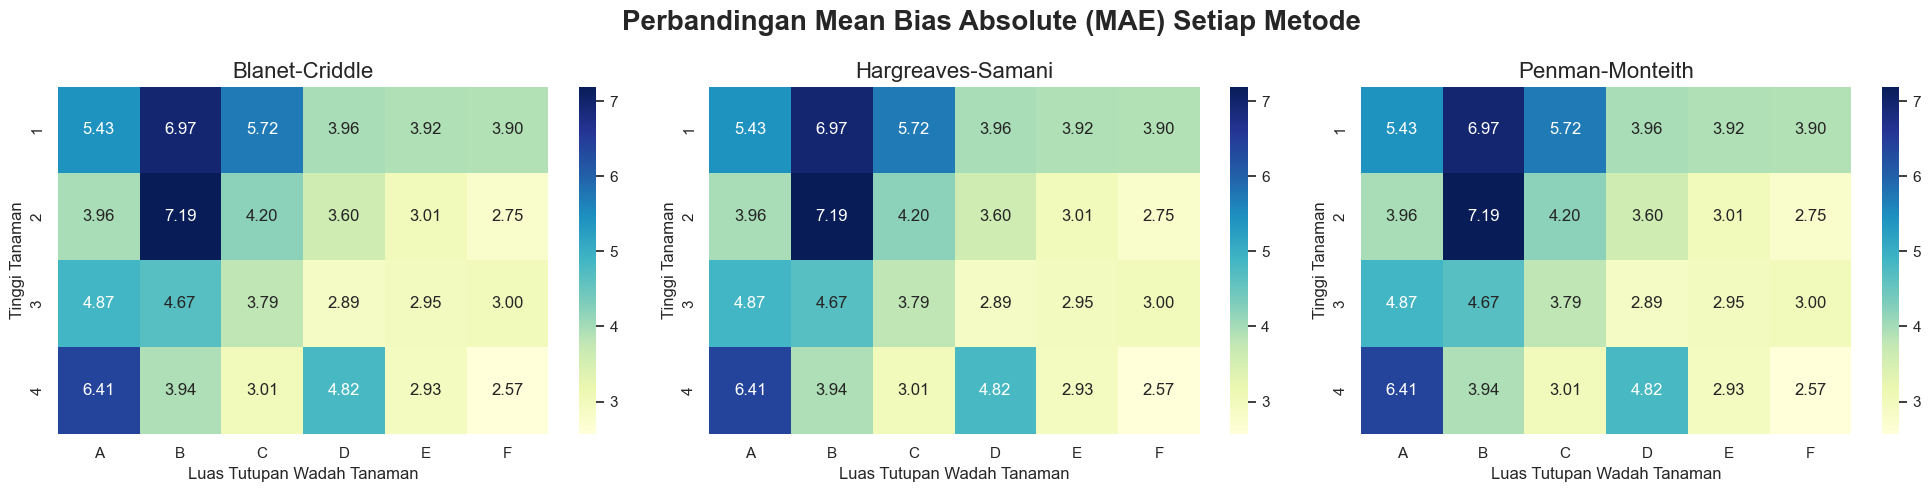

In [10]:
# Pastikan kolom dataframe dalam format string
df_mae.columns = df_mae.columns.astype(str)

# Ekstraksi kategori (A-F) dan nomor (1-4) dari kolom
df_mae.columns = [col[0] + col[1] for col in df_mae.columns.str.extract(r'([A-F])([1-4])').values]
df_mae.index.name = "Metode"

# Reshape data
df_mae_long = df_mae.reset_index().melt(id_vars="Metode", var_name="CategoryNumber", value_name="Akurasi")
df_mae_long[['Category', 'Number']] = df_mae_long['CategoryNumber'].str.extract(r'([A-F])([1-4])')
df_mae_long.drop(columns=['CategoryNumber'], inplace=True)

# Menentukan rentang warna (vmin, vmax) berdasarkan data keseluruhan
vmin = df_mae_long['Akurasi'].min()
vmax = df_mae_long['Akurasi'].max()

# Generate heatmaps untuk setiap metode
methods = df_mae.index
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, method in enumerate(methods):
    # Filter data untuk metode tertentu
    heatmap_data = df_mae_long[df_mae_long['Metode'] == method].pivot(index="Number", columns="Category", values="Akurasi")
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax, ax=axes[i])
    axes[i].set_title(method, fontsize=16)
    axes[i].set_xlabel("Luas Tutupan Wadah Tanaman")
    axes[i].set_ylabel("Tinggi Tanaman")

fig.suptitle("Perbandingan Mean Bias Absolute (MAE) Setiap Metode", fontsize=20, weight='bold')
plt.tight_layout()
plt.show()

## Root Mean Square Error (RMSE)

In [11]:
rmse_bc = {}
rmse_hs = {}
rmse_pm = {}

# Menghitung RMSE untuk setiap kolom
for col in aktual.columns:
    rmse_bc[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_bc))
    rmse_hs[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_hs))
    rmse_pm[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_pm))

# Membuat dataframe untuk RMSE
df_rmse = pd.DataFrame({
    'Blanet-Criddle': rmse_bc,
    'Hargreaves-Samani': rmse_hs,
    'Penman-Monteith': rmse_pm
}).T

# Menampilkan hasil
df_rmse.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Blanet-Criddle,5.683326,4.549071,5.338363,7.140102,7.661853,7.976641,5.460430,4.892291,6.473288,4.784182,...,3.590229,5.787187,4.807191,3.704571,3.669826,3.679922,4.265515,3.279853,3.279383,2.989025
Hargreaves-Samani,7.068257,6.034509,6.883853,8.604814,9.177137,9.531951,6.946227,6.373076,7.979068,6.163715,...,5.007723,7.012228,5.772969,5.130901,4.611998,4.664640,3.422837,2.724781,3.250703,3.219352
Penman-Monteith,7.832763,6.921302,7.723012,9.430036,10.004318,10.363537,7.792202,7.207630,8.780380,6.889894,...,5.858407,7.666103,6.451142,6.012127,5.305463,5.365628,3.241586,2.842280,3.649634,3.812861


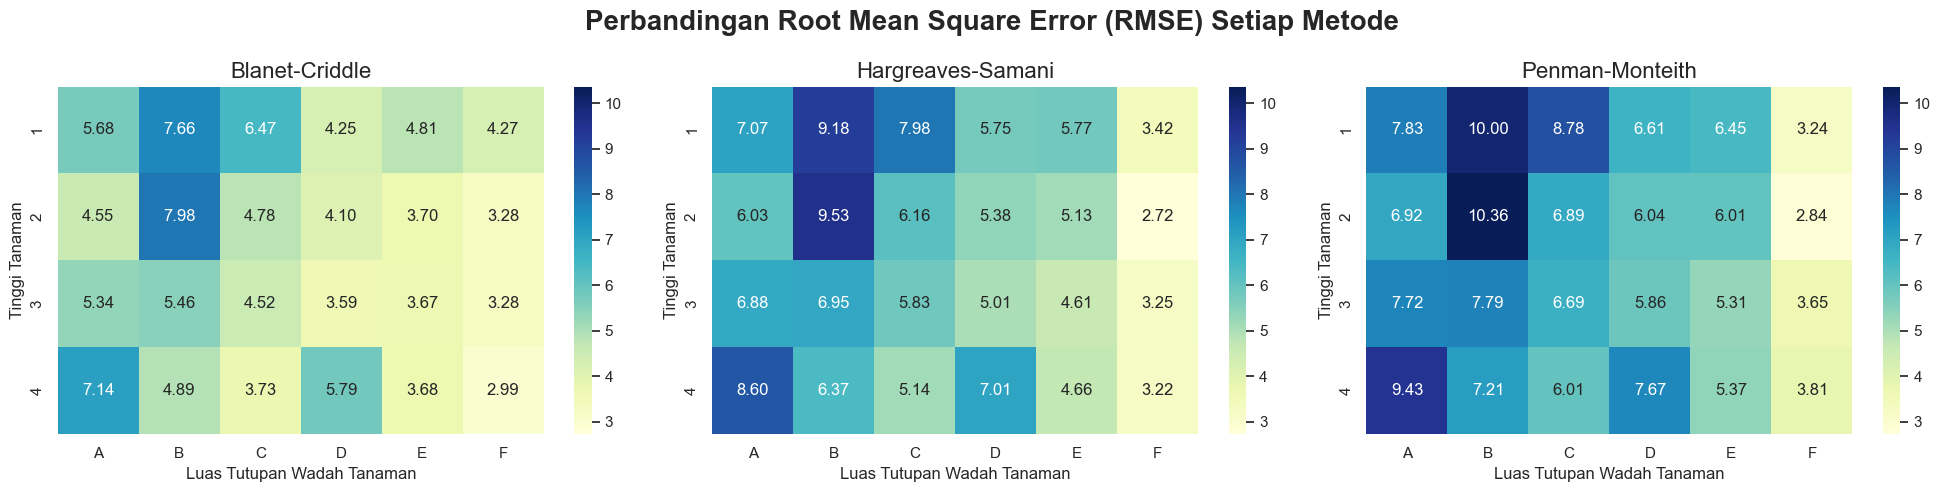

In [12]:
# Pastikan kolom dataframe dalam format string
df_rmse.columns = df_rmse.columns.astype(str)

# Ekstraksi kategori (A-F) dan nomor (1-4) dari kolom
df_rmse.columns = [col[0] + col[1] for col in df_rmse.columns.str.extract(r'([A-F])([1-4])').values]
df_rmse.index.name = "Metode"

# Reshape data
df_rmse_long = df_rmse.reset_index().melt(id_vars="Metode", var_name="CategoryNumber", value_name="Akurasi")
df_rmse_long[['Category', 'Number']] = df_rmse_long['CategoryNumber'].str.extract(r'([A-F])([1-4])')
df_rmse_long.drop(columns=['CategoryNumber'], inplace=True)

# Menentukan rentang warna (vmin, vmax) berdasarkan data keseluruhan
vmin = df_rmse_long['Akurasi'].min()
vmax = df_rmse_long['Akurasi'].max()

# Generate heatmaps untuk setiap metode
methods = df_rmse.index
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, method in enumerate(methods):
    # Filter data untuk metode tertentu
    heatmap_data = df_rmse_long[df_rmse_long['Metode'] == method].pivot(index="Number", columns="Category", values="Akurasi")
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax, ax=axes[i])
    axes[i].set_title(method, fontsize=16)
    axes[i].set_xlabel("Luas Tutupan Wadah Tanaman")
    axes[i].set_ylabel("Tinggi Tanaman")

fig.suptitle("Perbandingan Root Mean Square Error (RMSE) Setiap Metode", fontsize=20, weight='bold')
plt.tight_layout()
plt.show()

## Mean Bias Error (MBE)

In [13]:
mbe_bc = {}
mbe_hs = {}
mbe_pm = {}

# Menghitung MBE untuk setiap kolom
for col in aktual.columns:
    mbe_bc[col] = np.mean(estimasi_bc - aktual[col])
    mbe_hs[col] = np.mean(estimasi_hs - aktual[col])
    mbe_pm[col] = np.mean(estimasi_pm - aktual[col])

# Membuat dataframe untuk MBE
df_mbe = pd.DataFrame({
    'Blanet-Criddle': mbe_bc,
    'Hargreaves-Samani': mbe_hs,
    'Penman-Monteith': mbe_pm
}).T

# Menampilkan hasil
df_mbe.head()


,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Blanet-Criddle,-4.607030,-3.960630,-4.869430,-6.407030,-6.498630,-7.193074,-4.667519,-3.935297,-5.722916,-3.577242,...,-2.754880,-3.663630,-1.683198,-2.789864,-1.103939,-1.447642,3.340170,2.295770,1.499770,0.836970
Hargreaves-Samani,-6.182931,-5.536531,-6.445331,-7.982931,-8.074531,-8.768976,-6.243420,-5.511198,-7.298817,-5.153143,...,-4.330781,-5.239531,-3.259099,-4.365766,-2.679840,-3.023543,1.764269,0.719869,-0.076131,-0.738931
Penman-Monteith,-7.047297,-6.400897,-7.309697,-8.847297,-8.938897,-9.633341,-7.107785,-6.375563,-8.163182,-6.017509,...,-5.195147,-6.103897,-4.123464,-5.230131,-3.544205,-3.887909,0.899903,-0.144497,-0.940497,-1.603297


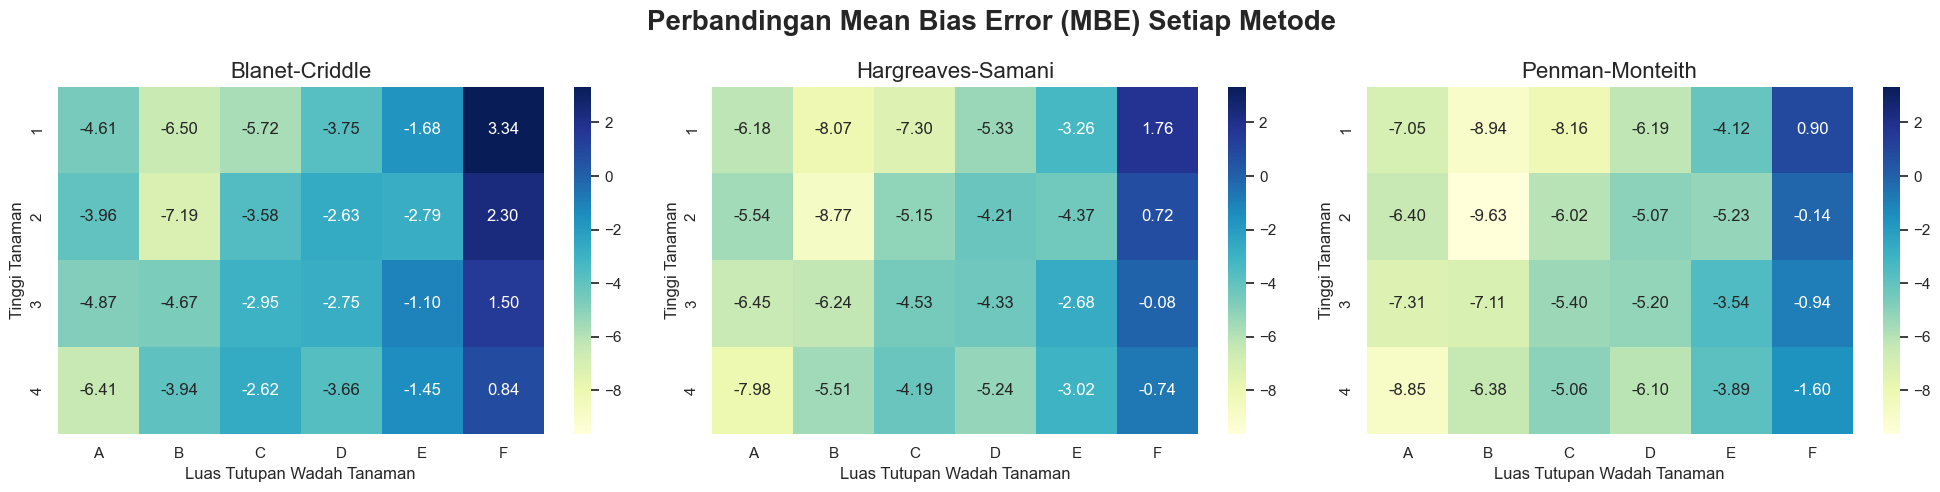

In [14]:
# Pastikan kolom dataframe dalam format string
df_mbe.columns = df_mbe.columns.astype(str)

# Ekstraksi kategori (A-F) dan nomor (1-4) dari kolom
df_mbe.columns = [col[0] + col[1] for col in df_mbe.columns.str.extract(r'([A-F])([1-4])').values]
df_mbe.index.name = "Metode"

# Reshape data
df_mbe_long = df_mbe.reset_index().melt(id_vars="Metode", var_name="CategoryNumber", value_name="Akurasi")
df_mbe_long[['Category', 'Number']] = df_mbe_long['CategoryNumber'].str.extract(r'([A-F])([1-4])')
df_mbe_long.drop(columns=['CategoryNumber'], inplace=True)

# Menentukan rentang warna (vmin, vmax) berdasarkan data keseluruhan
vmin = df_mbe_long['Akurasi'].min()
vmax = df_mbe_long['Akurasi'].max()

# Generate heatmaps untuk setiap metode
methods = df_mbe.index
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, method in enumerate(methods):
    # Filter data untuk metode tertentu
    heatmap_data = df_mbe_long[df_mbe_long['Metode'] == method].pivot(index="Number", columns="Category", values="Akurasi")
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax, ax=axes[i])
    axes[i].set_title(method, fontsize=16)
    axes[i].set_xlabel("Luas Tutupan Wadah Tanaman")
    axes[i].set_ylabel("Tinggi Tanaman")

fig.suptitle("Perbandingan Mean Bias Error (MBE) Setiap Metode", fontsize=20, weight='bold')
plt.tight_layout()
plt.show()

# RM 2 - Anova

In [15]:
df_data_anova = pd.read_csv('hasil/Data Anova.csv')
df_data_anova.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah
0,A1,day 05,2.181938,78100.0,25,156.25
1,A2,day 05,3.039563,78100.0,40,156.25
2,A3,day 05,3.915938,78100.0,45,156.25
3,A4,day 05,3.264563,78100.0,60,156.25
4,B1,day 05,3.590562,78100.0,25,225.00


## Blaney-Criddle

In [16]:
df_data_anova_bc = df_data_anova.merge(df_bc, left_on="Day", right_on="Num Day", how="left")
df_data_anova_bc = df_data_anova_bc.drop(columns=["Num Day", "Mean Suhu Udara"])
df_data_anova_bc = df_data_anova_bc.rename(columns={'ET Total': 'ET_BC'})
df_data_anova_bc.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah,Tanggal,ET_BC
0,A1,day 05,2.181938,78100.0,25,156.25,2024-10-26,5.998712
1,A2,day 05,3.039563,78100.0,40,156.25,2024-10-26,5.998712
2,A3,day 05,3.915938,78100.0,45,156.25,2024-10-26,5.998712
3,A4,day 05,3.264563,78100.0,60,156.25,2024-10-26,5.998712
4,B1,day 05,3.590562,78100.0,25,225.00,2024-10-26,5.998712


In [17]:
model = ols('ET_BC ~ C(Tinggi_Tanaman) + C(Luas_Permukaan_Wadah) + C(Intensitas_Matahari)', data=df_data_anova_bc).fit()
anova_bc = sm.stats.anova_lm(model, typ=2)
print("Anova Tabel untuk Metode Blaney-Criddle")
print(anova_bc)

Anova Tabel untuk Metode Blaney-Criddle
                               sum_sq     df             F    PR(>F)
C(Tinggi_Tanaman)        2.042248e-27    3.0  4.802712e+00  0.002917
C(Luas_Permukaan_Wadah)  3.047338e-28    5.0  4.299818e-01  0.827456
C(Intensitas_Matahari)   5.701433e+00    9.0  4.469315e+27  0.000000
Residual                 3.146687e-26  222.0           NaN       NaN


## Hargreaves-Samani

In [18]:
df_data_anova_hs = df_data_anova.merge(df_hs, left_on="Day", right_on="Num Day", how="left")
df_data_anova_hs = df_data_anova_hs.drop(columns=["Num Day", "Mean Suhu Udara", "Max Suhu Udara", "Min Suhu Udara", "Min Suhu Udara", "Radiasi Extrateresterial"])
df_data_anova_hs = df_data_anova_hs.rename(columns={'ET Total': 'ET_HS'})
df_data_anova_hs.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah,Tanggal,ET_HS
0,A1,day 05,2.181938,78100.0,25,156.25,2024-10-26,4.681888
1,A2,day 05,3.039563,78100.0,40,156.25,2024-10-26,4.681888
2,A3,day 05,3.915938,78100.0,45,156.25,2024-10-26,4.681888
3,A4,day 05,3.264563,78100.0,60,156.25,2024-10-26,4.681888
4,B1,day 05,3.590562,78100.0,25,225.00,2024-10-26,4.681888


In [19]:
model = ols('ET_HS ~ C(Tinggi_Tanaman) + C(Luas_Permukaan_Wadah) + C(Intensitas_Matahari)', data=df_data_anova_hs).fit()
anova_hs = sm.stats.anova_lm(model, typ=2)
print("Anova Tabel untuk Hargreaves-Samani")
print(anova_hs)

Anova Tabel untuk Hargreaves-Samani
                               sum_sq     df             F        PR(>F)
C(Tinggi_Tanaman)        4.318831e-28    3.0  2.383135e+01  2.077185e-13
C(Luas_Permukaan_Wadah)  1.495557e-28    5.0  4.951497e+00  2.558591e-04
C(Intensitas_Matahari)   7.478383e+01    9.0  1.375526e+30  0.000000e+00
Residual                 1.341064e-27  222.0           NaN           NaN


## Penman-Monteith

In [20]:
df_data_anova_pm = df_data_anova.merge(df_pm, left_on="Day", right_on="Num Day", how="left")
df_data_anova_pm = df_data_anova_pm.drop(columns=["Num Day", "Mean Suhu Udara", "Max Suhu Udara", "Min Suhu Udara", "Min Suhu Udara", "Radiasi Extrateresterial", "Mean Kecepatan Angin", "Mean Kelembapan Relatif"])
df_data_anova_pm = df_data_anova_pm.rename(columns={'ET Total': 'ET_PM'})
df_data_anova_pm.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah,Tanggal,ET_PM
0,A1,day 05,2.181938,78100.0,25,156.25,2024-10-26,4.104162
1,A2,day 05,3.039563,78100.0,40,156.25,2024-10-26,4.104162
2,A3,day 05,3.915938,78100.0,45,156.25,2024-10-26,4.104162
3,A4,day 05,3.264563,78100.0,60,156.25,2024-10-26,4.104162
4,B1,day 05,3.590562,78100.0,25,225.00,2024-10-26,4.104162


In [21]:
model = ols('ET_PM ~ C(Tinggi_Tanaman) + C(Luas_Permukaan_Wadah) + C(Intensitas_Matahari)', data=df_data_anova_pm).fit()
anova_pm = sm.stats.anova_lm(model, typ=2)
print("Anova Tabel untuk Penman-Monteith")
print(anova_pm)

Anova Tabel untuk Penman-Monteith
                               sum_sq     df             F    PR(>F)
C(Tinggi_Tanaman)        1.017492e-27    3.0  6.060990e+00  0.000554
C(Luas_Permukaan_Wadah)  2.110174e-28    5.0  7.541926e-01  0.583802
C(Intensitas_Matahari)   1.782839e+02    9.0  3.540003e+29  0.000000
Residual                 1.242278e-26  222.0           NaN       NaN
